#  Matching Catalogs by Members ID

---
**License**

 Matching Catalogs by Members ID

 Tue Aug 24 10:30:00 2021\
 Copyright  2021\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 Ascaso_Extended_cDC2_RM_Test\
 Copyright (C) 2021 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Libraries & Configs

In [1]:
import math
import sys

import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
import pandas as pd

sys.path.insert(0, "/global/homes/c/cinlima/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/c/cinlima/")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/MachingCatalogs")


import GCRCatalogs
#Put nersc if using nersc
GCRCatalogs.set_root_dir_by_site("nersc")

print('GCRCatalogs =', GCRCatalogs.__version__, '|' ,'GCR =', GCRCatalogs.GCR.__version__)


from numcosmo_py import Nc, Ncm

# from mtdc2 import mtrmdc2

import time

# GCRCatalogs.get_available_catalog_names()
print('Numpy =', np.__version__)

GCRCatalogs = 1.9.0 | GCR = 0.9.2
GCRCatalogs = 1.26.4


## Catalogs

In [2]:
#Cosmo DC2
cosmodc2= GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

#Cosmo DC2 + RedMaPPer
catalog_dc2_redmapper = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.8.1')



In [3]:
# Restrictions on richness, mass and redshift
min_richness = 5
min_halo_mass = 1e13 #Msun
redshift_max = 1.2

#cDC2 + RM data
quantities = catalog_dc2_redmapper.list_all_quantities()
cluster_quantities = [q for q in quantities if 'member' not in q]
member_quantities = [q for q in quantities if 'member' in q]
    
query = GCRCatalogs.GCRQuery('(richness > ' + str(min_richness) +')')
cluster_data = Table(catalog_dc2_redmapper.get_quantities(cluster_quantities, [query])) # cDC2 + RM cluster data
member_data = Table(catalog_dc2_redmapper.get_quantities(member_quantities)) # cDC2 + RM member data

#cDC2 data
quantities_wanted = ['redshift','halo_mass','halo_id','galaxy_id','ra','dec', 'is_central']
query = GCRCatalogs.GCRQuery('(halo_mass > ' + str(min_halo_mass) +') & (redshift < ' + str(redshift_max) +') & (is_central < ' + str(redshift_max) +') ')
truth_data = Table(cosmodc2.get_quantities(quantities_wanted, [query]))

In [96]:
# truth_data[truth_data['is_central'] == True]

# cluster_data.to_pandas().head()


## cDC2 and cDC2 + RM Catalogs Match

In [5]:
memberdf = member_data.to_pandas().rename(columns={'id_member': 'id'}) #This creates a dataframe and rename: id_member -> id (cDC2 + RM MEMBERS).
truthdf = truth_data.to_pandas().rename(columns={'galaxy_id': 'id'}) #This creates a dataframe and rename: galaxy_id -> id (cDC2 MEMBERS).

cluster_df=cluster_data.to_pandas()[['richness', 'richness_err', 'cluster_id', 'redshift', 'redshift_err', 'ra', 'dec']].rename(columns={'ra': 'cluster_ra', 'dec': 'cluster_dec', 'redshift': 'cluster_redshift', 'redshift_err': 'cluster_redshift_err'}) #This creates a dataframe for cDC2 clusters.

In [97]:
# memberdf

In [98]:
# truthdf

In [99]:
# cluster_df

In [94]:
memberdf[memberdf['id'] == 1312946359]['redshift_true_member']

4    0.510501
Name: redshift_true_member, dtype: float32

In [95]:
truthdf[truthdf['id'] == 1312946359]['redshift']

1258053    0.510501
Name: redshift, dtype: float64

In [100]:
Mt_df = pd.merge(memberdf['id'], truthdf['id'], how='inner', on=['id']) #This selects commom members ID from cDC2 and cDC2 + RM data
# Mt_df

In [101]:
mt_member = pd.merge(memberdf, Mt_df, how='inner', on=['id']) #This selects the matching members using Mt_df IDs
# mt_member

In [102]:
idc = mt_member[['id', 'cluster_id_member']].rename(columns={'cluster_id_member': 'cluster_id'}) #This selects the members and clusters IDs
# idc

In [103]:
mt_cluster = pd.merge(idc, cluster_df, how='inner', on=['cluster_id']) #This selects the clusters data by idc IDS 
# mt_cluster

In [104]:
mt_catalog = pd.merge(mt_cluster, truthdf, how='inner', on=['id']) #This creates the matching catalog with clustes and halos
# mt_catalog

In [105]:
clusters_id = mt_catalog[mt_catalog['is_central'] == True]['cluster_id'].unique() #This selects the clusters IDs

# clusters_id

In [72]:
mt_catalog['freq'] = mt_catalog.groupby(['cluster_id', 'halo_id'])['halo_id'].transform('count') # This Adds a frequency column for each halo ID
                                                                                                 # in mt_catalog.
mt_catalog.head()

,id,cluster_id,richness,richness_err,cluster_redshift,cluster_redshift_err,cluster_ra,cluster_dec,halo_mass,ra,redshift,halo_id,dec,is_central,freq
0,1312945563,10,190.70665,3.746967,0.513513,0.002786,52.520436,-25.717996,5.461543e+14,52.520436,0.510724,1162500021323,-25.717996,True,96
1,1312932492,10,190.70665,3.746967,0.513513,0.002786,52.520436,-25.717996,5.461543e+14,52.519490,0.513088,205900021323,-25.717833,True,86
2,1312932655,10,190.70665,3.746967,0.513513,0.002786,52.520436,-25.717996,5.461543e+14,52.518707,0.523674,205900021323,-25.717501,False,86
3,1312946401,10,190.70665,3.746967,0.513513,0.002786,52.520436,-25.717996,5.461543e+14,52.518979,0.510740,1162500021323,-25.716904,False,96
4,1312946359,10,190.70665,3.746967,0.513513,0.002786,52.520436,-25.717996,5.461543e+14,52.523239,0.510501,1162500021323,-25.717097,False,96


In [69]:
iscentral = mt_catalog[mt_catalog['is_central'] == True] #This selects the central members

iscentral.head(4)


iscentral[['id','cluster_id','halo_id', 'cluster_ra', 'ra',
                                             'cluster_dec', 'dec', 'cluster_redshift', 'redshift',
                                             'cluster_redshift_err', 'richness', 'richness_err', 'halo_mass', 'is_central' ]].head(4)

,id,cluster_id,halo_id,cluster_ra,ra,cluster_dec,dec,cluster_redshift,redshift,cluster_redshift_err,richness,richness_err,halo_mass,is_central
0,1312945563,10,1162500021323,52.520436,52.520436,-25.717996,-25.717996,0.513513,0.510724,0.002786,190.70665,3.746967,5.461543e+14,True
1,1312932492,10,205900021323,52.520436,52.519490,-25.717996,-25.717833,0.513513,0.513088,0.002786,190.70665,3.746967,5.461543e+14,True
33,1313029113,10,711400021315,52.520436,52.519101,-25.717996,-25.727465,0.513513,0.568313,0.002786,190.70665,3.746967,8.179136e+13,True
165,1312930910,10,80500021323,52.520436,52.472525,-25.717996,-25.716806,0.513513,0.508254,0.002786,190.70665,3.746967,1.158516e+13,True


In [ ]:
# gcut = iscentral.groupby('cluster_id').get_group(10)


In [ ]:
# gcut[(gcut['redshift'] > gcut['cluster_redshift'] - gcut['cluster_redshift_err']) & (gcut['redshift'] < gcut['cluster_redshift'] + gcut['cluster_redshift_err'])  ] 

# ra_cut = (gcut['ra'] > gcut['cluster_ra'] - 1e-4) & (gcut['ra'] < gcut['cluster_ra'] + 1e-4) 
# dec_cut = (gcut['dec'] > gcut['cluster_dec'] - 1e-4) & (gcut['dec'] < gcut['cluster_dec'] + 1e-4)
# gcut = gcut[ra_cut & dec_cut]
# gcut

In [64]:
# This loop creates the unique matching catalog using the halo ID frequency. It selects the halos with maximum frequency.

idgroups = iscentral.groupby('cluster_id') # It groups data by cluster_id. 

inicio = time.time()

match_dataframe = pd.DataFrame()                                                                                                                                                                            #
for cl in clusters_id:                                                                                        
    gcut = idgroups.get_group(cl)
    
    ra_cut = (gcut['ra'] > gcut['cluster_ra'] - 1e-4) & (gcut['ra'] < gcut['cluster_ra'] + 1e-4) 
    dec_cut = (gcut['dec'] > gcut['cluster_dec'] - 1e-4) & (gcut['dec'] < gcut['cluster_dec'] + 1e-4)
    
    gcut = gcut[ra_cut & dec_cut]

    if len(gcut) == 1:
        match_dataframe = pd.concat([match_dataframe, gcut], ignore_index=True)
        
    elif len(gcut) == 0:
        pass
        
    else:
        gcut = gcut[gcut['freq'] == gcut['freq'].max()]
        match_dataframe = pd.concat([match_dataframe, gcut], ignore_index=True)
    
fim = time.time()


In [65]:
print(f'total time = {fim - inicio :.2f} seconds')


total time = 49.20 seconds


In [63]:
match_dataframe

,id,cluster_id,richness,richness_err,cluster_redshift,cluster_redshift_err,cluster_ra,cluster_dec,halo_mass,ra,redshift,halo_id,dec,is_central,freq
0,1312945563,10,190.706650,3.746967,0.513513,0.002786,52.520436,-25.717996,5.461543e+14,52.520436,0.510724,1162500021323,-25.717996,True,96
1,2000524808,18,179.128128,3.693436,0.571270,0.003218,56.920377,-27.204341,1.009535e+15,56.920377,0.574030,549500032315,-27.204341,True,189
2,2002535198,24,124.027153,2.417291,1.040338,0.006518,56.998497,-26.717208,3.818845e+14,56.998497,1.034776,2554900032241,-26.717208,True,128
3,2000759779,30,167.336029,3.677716,0.635185,0.006033,58.563624,-27.429962,3.884919e+14,58.563624,0.642617,1275900032300,-27.429962,True,186
4,2000289335,71,111.914703,3.366554,0.442303,0.003674,58.355198,-26.867687,3.569262e+14,58.355198,0.439197,359200032338,-26.867687,True,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31687,12003345128,35906,5.984163,1.327839,1.149191,0.012147,71.608889,-45.826514,8.607690e+13,71.608889,1.197068,2017200192224,-45.826514,True,11
31688,11315892952,6928,17.501669,1.679644,1.135227,0.007037,69.227644,-43.144912,6.707982e+13,69.227644,1.168442,4041900181224,-43.144912,True,18
31689,11940608972,21720,10.819990,1.563317,1.133446,0.007788,67.806866,-45.049689,7.055515e+13,67.806866,1.131637,2358500191230,-45.049689,True,13
31690,12000459039,54206,5.282434,1.234711,0.501281,0.008677,70.472970,-44.819294,1.931144e+13,70.472970,0.506876,958400192323,-44.819294,True,6


In [37]:
match_dataframe_organized = match_dataframe[['id','cluster_id','halo_id', 'cluster_ra', 'ra',
                                             'cluster_dec', 'dec', 'cluster_redshift', 'redshift',
                                             'cluster_redshift_err', 'richness', 'richness_err', 'halo_mass', 'is_central' ]]


In [51]:
#Table.from_pandas(match_dataframe_organized).write('match_ID.fits', overwrite=True)

## Data Analysis

### Duplicates

In [52]:
if True in match_dataframe_organized['halo_id'].duplicated():
    df_test_matchdata[df_test_matchdata['halo_id'].duplicated()]
else:
    print( "Duplicated halos don't exists.")

Duplicated halos don't exists.


In [53]:
if True in match_dataframe_organized['cluster_id'].duplicated():
    df_test_matchdata[df_test_matchdata['cluster_id'].duplicated()]
else:
    print( "Duplicated clusters don't exists.")

Duplicated clusters don't exists.


In [54]:
if True in match_dataframe_organized['id'].duplicated():
    df_test_matchdata[df_test_matchdata['id'].duplicated()]
else:
    print( "Duplicated members don't exists.")

Duplicated members don't exists.


### RA, Dec, Redshift

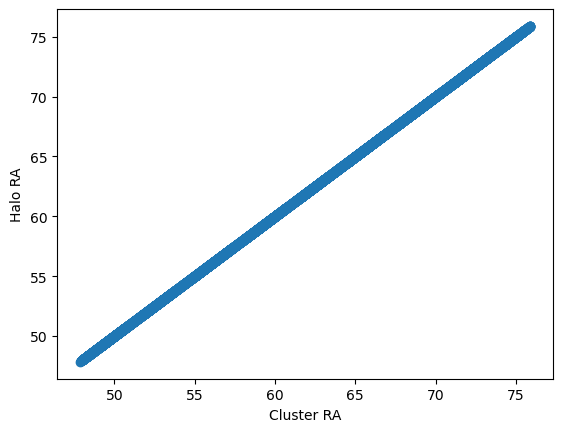

In [55]:
plt.scatter(match_dataframe_organized['cluster_ra'], match_dataframe_organized['ra'])

plt.xlabel('Cluster RA')
plt.ylabel('Halo RA')
plt.show()

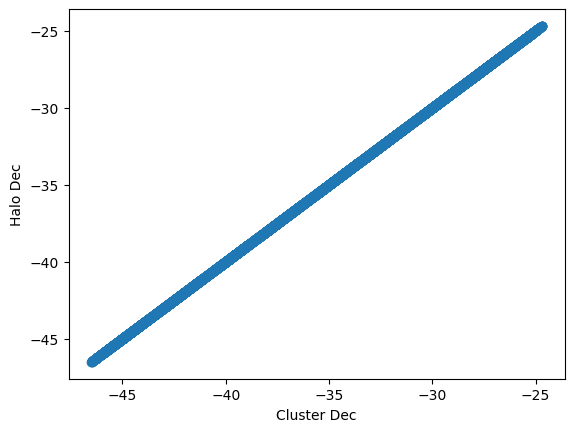

In [56]:
plt.scatter(match_dataframe_organized['cluster_dec'], match_dataframe_organized['dec'])

plt.xlabel('Cluster Dec')
plt.ylabel('Halo Dec')
plt.show()

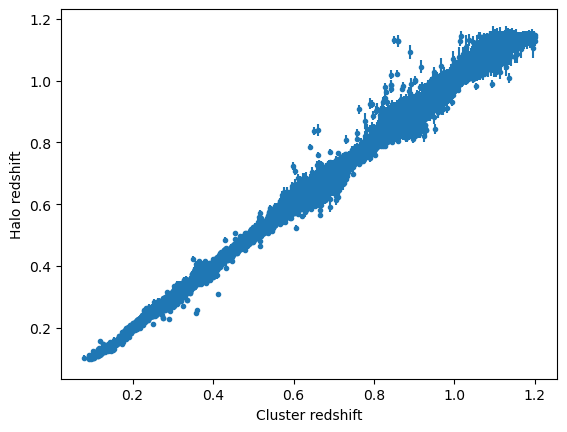

In [57]:
zdf = match_dataframe_organized.sort_values(by='redshift')

x = match_dataframe_organized['redshift']
y = match_dataframe_organized['cluster_redshift']
y_err = match_dataframe_organized['cluster_redshift_err']

# plt.scatter(x, y)

plt.errorbar(x, y, yerr = y_err, fmt=".")

plt.xlabel('Cluster redshift')
plt.ylabel('Halo redshift')
plt.show()



### Richness x Mass

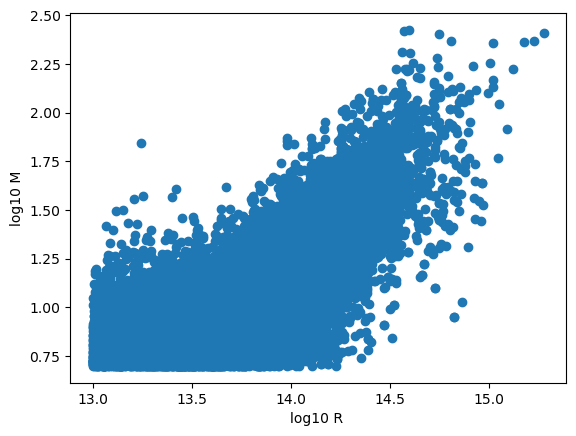

In [58]:
plt.scatter(np.log10(match_dataframe_organized['halo_mass']), np.log10(match_dataframe_organized['richness']))

plt.xlabel('log10 R ')
plt.ylabel('log10 M')
plt.show()

## tests

In [59]:
# inicio = time.time()

# mt_dataframe2 = mtrmdc2(member_data, cluster_data, truth_data)

# fim = time.time()
# tempo_total = fim - inicio

# print(f"Tempo de execução: {tempo_total/60:.3}min")

In [60]:
# mt_dataframe

In [61]:
# mt_table = Table.from_pandas(match_dataframe)

In [62]:
# mt_table.write('match_ID.fits')